In [1]:
from __future__ import division

from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

import sphereml
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py
import cma
import lcmaes
from fitness_function import evaluate

import time
from joblib import Parallel, delayed
from persistence import save, load
import pyformulas as pf

factor=1.3					# area of plot

In [2]:
#limitsdict = {'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}
limitsdict = {'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.0)}

def plot_hist(hist, label, linestyle='-'):
    histarr = np.array(hist)
    xs,ys = histarr[:,0],histarr[:,1]
    plt.plot(xs, ys, linestyle=linestyle, label=label)

In [3]:
%%time

def run_evaluation(algo, n_it, r_limits, m_limits, mj_limits, layers, evaluate=evaluate,
                   popsize=None, sbbx_eta=1.0,
                   cmaAlgo='CMAAdaptSigmaTPA',
                   log=True, seed=283636):
    def helper(ind):
        helper.calls += 1
        return evaluate(ind, layers=layers)
    helper.calls = 0
    
    hist = []
    limits = [r_limits]*layers+[m_limits,mj_limits]*layers+[(0.1, r_limits[-1]*factor)]
    
    if popsize is None: popsize = 5*len(limits)
    if popsize > n_it: raise AssertionError(f"popsize({popsize}) should be < n_it({n_it})")
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=popsize, limits=limits)
        for _ in range(int(n_it/popsize)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, -func(magic_cast(xk))))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=popsize, maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=popsize, generations=n_it, sbbx_eta=sbbx_eta, log=False,
                            callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    elif algo == 'CMA-py' or algo == 'CMA':
        lb = np.array(list(map(lambda t: t[0], limits)))
        rb = np.array(list(map(lambda t: t[1], limits)))
        
        scale_linear = lambda x, a, b: a + (b-a) * (x/10)
        scale_quadratic = lambda x, a, b: a + (b-a) * ((x/10) ** 2)
        #scale_log = lambda x, a, b: lb * (rb/lb) ** (np.array(x)/10)
        
        def scaled_func(x):
            assert layers == 2
            #x = np.array(x)
            #print(x)
            
            real_x = [
                scale_quadratic(x[0], lb[0], rb[0]),
                scale_quadratic(x[1], lb[1], rb[1]),
            
                scale_linear(x[2], lb[2], rb[2]),
                scale_linear(x[3], lb[3], rb[3]),
                scale_linear(x[4], lb[4], rb[4]),
                scale_linear(x[5], lb[5], rb[5]),
            
                scale_quadratic(x[6], lb[6], rb[6])
            ]
            
            return -helper(real_x)
        
        if algo == 'CMA-py':
            initial = np.random.uniform(0, 10, len(limits)).tolist()
            sigma=2
            bounds=[0, 10]
            options={
                'bounds': bounds, 
                #'seed': seed,
                'AdaptSigma': cmaAlgo,
                'verbose': -9
            }
            global es
            global logger
            es = cma.CMAEvolutionStrategy(initial, sigma, options)
            logger = cma.CMADataLogger().register(es)
            for _ in range(n_it):
                (solutions, func_values) = es.ask_and_eval(scaled_func)
                es.tell(solutions, func_values)
                logger.add()
                es.disp()
                try:
                    fit, best = min(zip(func_values, solutions), key=lambda t: t[0])
                    fit = -fit
                except Exception:
                    print("{} {}".format(func_values, solutions))
                    assert False
                hist.append((helper.calls, fit))
                if helper.calls > n_it:
                    break
        elif algo == 'CMA':
            #x0 = list((rb + lb) / 2)
            #sigma0 = (rb.max() - lb.min()) / 3
            #x0 = [5] * len(limits)
            x0 = np.random.uniform(0, 10, len(limits)).tolist()
            sigma0 = 3.0
            #print(f'sigma is {sigma0}')

            str_algo=b'acmaes'
            #str_algo=b'bipop'
            #setx0
            gp = lcmaes.make_genopheno_pwqb([0] * len(limits), [10] * len(limits), len(limits))
            p = lcmaes.make_parameters_pwqb(x0,sigma0,gp)
            p.set_fplot("fplot.fplot")
            p.set_str_algo(str_algo)
            p.set_ftolerance(1e-40)
            #p.set_restarts(30)
            p.set_quiet(False)
            objfunc = lcmaes.fitfunc_pbf.from_callable(lambda x, n: scaled_func(x))

            def pfunc_raw(fitness):
                if np.isnan(fitness):
                    return 0
                hist.append((helper.calls, -fitness))
                if helper.calls > n_it:
                    #print("STOP")
                    return 1
                return 0

            pfunc = lcmaes.pfunc_pbf.from_callable(pfunc_raw)

            results = lcmaes.pcmaes_pwqb2(objfunc, p, pfunc)
            bestie = results.best_candidate()

            fit, best = -bestie.get_fvalue(), lcmaes.get_candidate_x(bestie)
    else:
        raise AssertionError("Unknown algo")
    
    if log:
        print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

def run_evaluations(runs=50, *args, **kwargs):
    res = []
    if runs < 0: # runs in minutes
        start = time.time()
        while time.time() - start < -runs * 60:
            _, _, hist = run_evaluation(*args, **kwargs)
            res.append(hist)
        return np.array(res)
        
    for run in range(runs):
        _, _, hist = run_evaluation(*args, **kwargs)
        res.append(hist)
    return np.array(res)

#_, cma_fit, cma_hist = run_evaluation('CMA-py', n_it=10000, layers=2, sbbx_eta=0.5, log=False, **limitsdict)
_, cma_fit, cma_hist = run_evaluation('CMA', n_it=10000, layers=2, sbbx_eta=0.5, log=False, **limitsdict)
print(f"res is {cma_fit}")

res is 8.392533706826486
CPU times: user 29.7 s, sys: 98.9 ms, total: 29.7 s
Wall time: 29.9 s


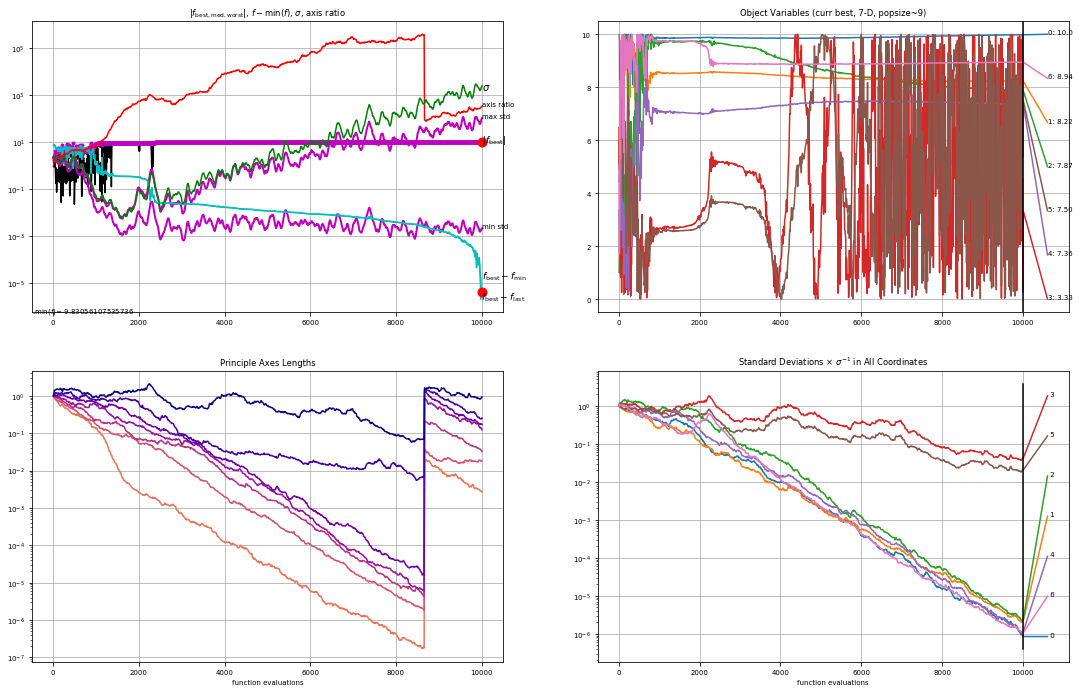

In [4]:
cma.plot();

In [18]:
%%time
best, _, hist = run_evaluation('JADE', n_it=10000, layers=2, sbbx_eta=0.5, log=False, **limitsdict)

CPU times: user 28.1 s, sys: 252 ms, total: 28.3 s
Wall time: 27.9 s


In [8]:
best

array([4.32457046e+01, 1.19756852e+02, 7.15328279e+00, 1.28869179e-01,
       1.00000000e+01, 6.24843803e-02, 1.30965740e+02])

In [10]:
%%time
_, cma_fit, cma_hist = run_evaluation('CMA', n_it=10000, layers=2, sbbx_eta=0.5, log=False, **limitsdict)
print(f"res is {cma_fit}")

res is 9.501053206797868
CPU times: user 27.3 s, sys: 60.4 ms, total: 27.4 s
Wall time: 27.2 s


In [10]:
%%time
_, _, jade_hist = run_evaluation('JADE', n_it=10000, layers=2, sbbx_eta=0.5, log=False, **limitsdict)
_, _, gen_hist = run_evaluation('genetic', n_it=10000, layers=2, sbbx_eta=0.5, log=False, **limitsdict)

CPU times: user 56 s, sys: 81.9 ms, total: 56.1 s
Wall time: 55.9 s


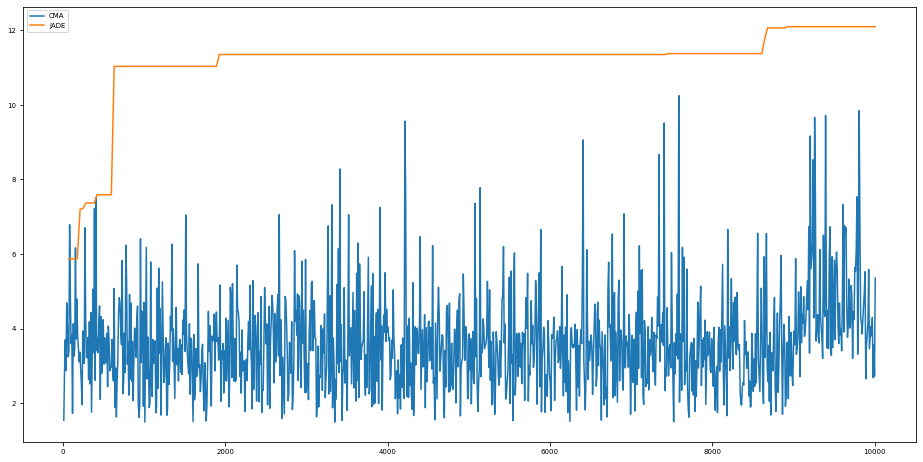

In [15]:
plt.figure(figsize=(16,8))
#plot_hist(gen_hist, label='genetic')
plot_hist(cma_hist, label='CMA')
plot_hist(jade_hist, label='JADE')
plt.legend();

In [9]:
j = run_evaluations(runs=5, algo='JADE', cmaAlgo=True, n_it=12000, layers=2, sbbx_eta=0.5, 
                    log=False, **limitsdict)

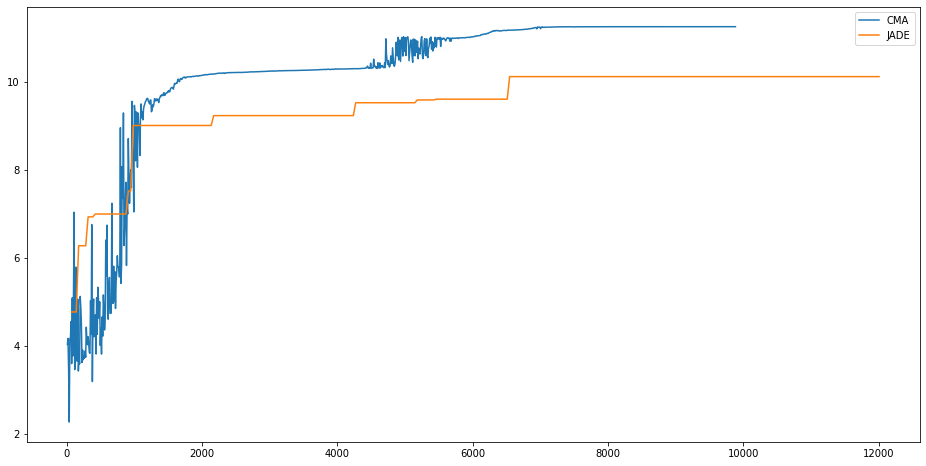

In [29]:
plt.figure(figsize=(16,8))
plot_hist(r[11], label='CMA')
plot_hist(j[0], label='JADE')
plt.legend();

In [16]:
%%time

n_it = 500000 # 25min
#RUNS=5

r = run_evaluations(runs=-300, algo='CMA', cmaAlgo=True, n_it=n_it, layers=2, sbbx_eta=0.5, 
                    log=False, **limitsdict)
save(r, f"results/cma/500000_{RUNS}runs")

CPU times: user 5h 57s, sys: 28.4 s, total: 5h 1min 26s
Wall time: 5h 19s


In [16]:
import libcmaes.python.cma_multiplt as cmaplt

In [17]:
cmaplt.plot("fplot.fplot")
cmaplt.pylab.ioff()
cmaplt.pylab.show()

<IPython.core.display.Javascript object>


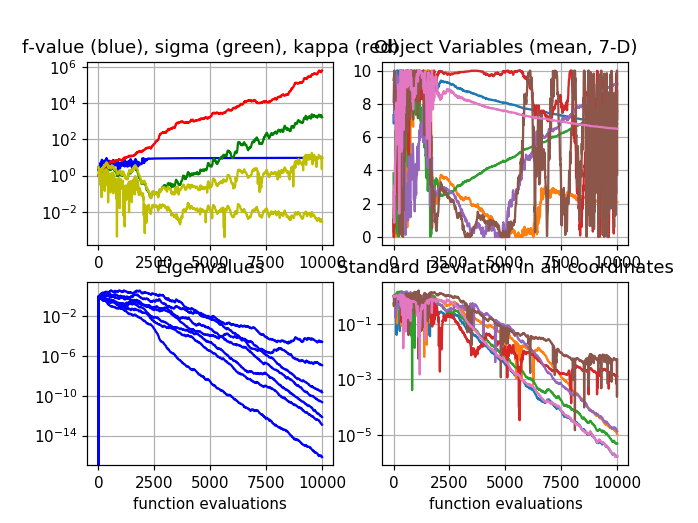

In [14]:
%matplotlib notebook

def plot_func(func_n):
    func = getattr(functions, f"f{func_n}")
    lb = functions.lbound[func_n - 1]
    rb = functions.rbound[func_n - 1]
    
    xs = np.linspace(lb, rb, 100)
    ys = np.linspace(lb, rb, 100)
    Xs, Ys = np.meshgrid(xs, ys)
    Zs = np.vectorize(lambda x, y: func(np.array([x, y])))(Xs, Ys)

    fig = plt.figure()#figsize=(16,10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(Xs, Ys, Zs, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');

plot_func(8)